In [2]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical 
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os


2023-08-17 18:24:01.191279: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-17 18:24:01.362409: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-17 18:24:01.362435: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-17 18:24:02.268746: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

In [3]:
filenames = os.listdir('archive/cats_dogs_cars/cats_dogs_cars/data')
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'car': 
        categories.append(0)  #The categories are set as labels
    elif category == 'cat': 
        categories.append(1)
    elif category == 'dog':
        categories.append(2)
        
df = pd.DataFrame({
    'filename': filenames,  
    'category': categories,    
})

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model2 = Sequential()

model2.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150,150, 3)))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Conv2D(64, (3, 3), activation='relu'))
model2.add(MaxPooling2D(pool_size=(2, 2)))
model2.add(Dropout(0.25))

model2.add(Flatten())
model2.add(Dense(96, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(3, activation='softmax')) # 3 because we have car, dog and cat classes

model2.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])

model2.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 74, 74, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 36, 36, 64)        0

2023-08-17 18:24:04.412263: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-08-17 18:24:04.412295: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-08-17 18:24:04.412314: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (IB-Pune-LAP-212): /proc/driver/nvidia/version does not exist
2023-08-17 18:24:04.412544: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                            patience=5, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001) 
callbacks = [earlystop, learning_rate_reduction]


2    959
0    794
1    792
Name: category, dtype: int64

 Total train images:  2545
Total train images: 2545
Total validate images: 637


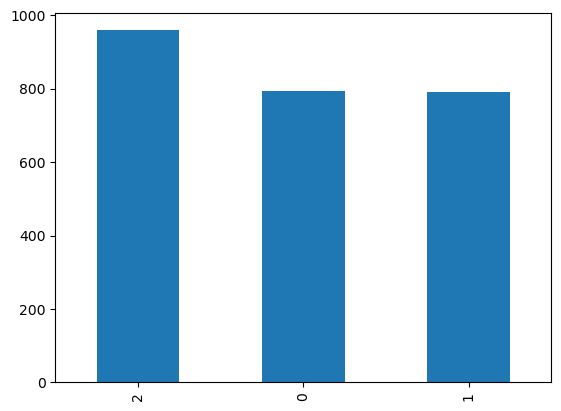

In [14]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=0) 

# Lets see total 'TRAIN' files and in each category
train_df = train_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()
print(train_df['category'].value_counts())
print("\n Total train images: ", train_df.shape[0])

# Get total train and validate, and batch size to fit model

total_train = train_df.shape[0]
print("Total train images:", total_train)

total_validate = validate_df.shape[0] 
print("Total validate images:", total_validate)

In [15]:
train_datagen = ImageDataGenerator(
                                    rotation_range=15,
                                    rescale=1./255,
                                    shear_range=0.1,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    width_shift_range=0.1,
                                    height_shift_range=0.1
)

validation_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "archive/cats_dogs_cars/cats_dogs_cars/data", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)

validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "archive/cats_dogs_cars/cats_dogs_cars/data", 
    x_col='filename',
    y_col='category',
    target_size=(150,150),
    class_mode='categorical',
    batch_size=32
)


TypeError: If class_mode="categorical", y_col="category" column values must be type string, list or tuple.

In [8]:
epochs=50
batch_size=50

history = model2.fit(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate/batch_size,
    steps_per_epoch=total_train/batch_size,
    callbacks=callbacks
)


NameError: name 'train_generator' is not defined

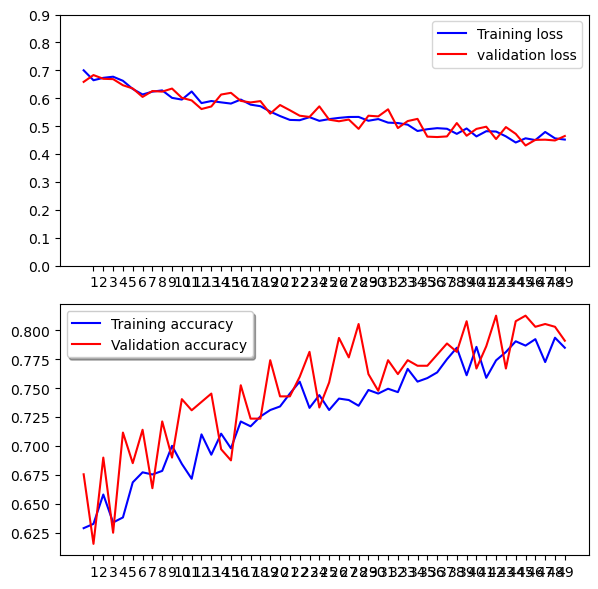

In [13]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6,6))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))
ax1.legend()

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))
ax2.legend()

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()


1/1 [==============================] - 0s 162ms/step
[2]


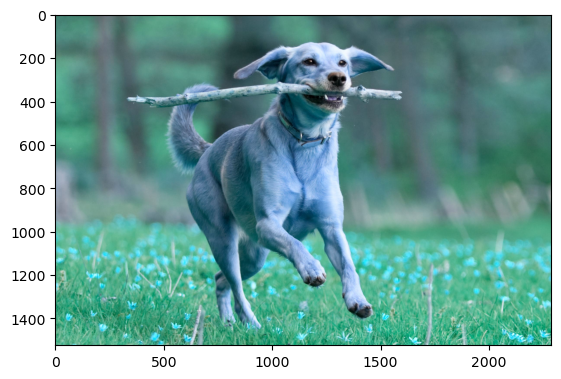

In [17]:
# Define the path to your image
# print(train_generator.class_indices) 
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing.image import img_to_array

import cv2
image_path = '_methode_times_prod_web_bin_77052c2a-0d22-11ed-93cf-b011fa7fe86b.jpg'
test_img = cv2.imread(image_path);
plt.imshow(test_img)

new_height, new_width = 150, 150  # Replace with your desired dimensions

# Create a custom generator for a single image
def single_image_generator(image_path, target_size):
    img = load_img(image_path, target_size=target_size)
    img_array = img_to_array(img)
    img_array = img_array.reshape((1,) + img_array.shape)  # Add a batch dimension
    img_array /= 255.0  # Rescale pixel values to [0, 1]
    return img_array

# Generate the preprocessed image using the custom generator
data_generator = single_image_generator(image_path, target_size=(new_height, new_width))

predict = model2.predict(data_generator)

print( np.argmax(predict, axis=-1) )


In [42]:
from tensorflow.keras.models import load_model
model2.save('multi_image_classification.h5')